# A causal approach to handling missing data

## Example
### Scenario
Given is an observational dataset with missing data in the diet adherence column. The goal is to use teh data to train an ML model that can predict Weight Loss. 

### Steps
1. Generate Datsets for MCAR, MAR and MNAR
2. Simple Analysis without handling missing data
3. Simple Imputation
4. Causal imputation using DAGs
5. MICE imputation using IterativeImputer from scikit-learn

### Variables
* Diet Adherence (continous)
* Weight Loss (continous)
* Initial Weight (continous)
* Age (continous)

In [740]:
# Imports
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

from sklearn.impute import IterativeImputer, SimpleImputer
from statsmodels.formula.api import ols

In [741]:
# Data Generation
np.random.seed(73)
data_size = 100
data = pd.DataFrame({
    'initial_weight': np.random.normal(70, 15, data_size), # mean weight of 70kg with a std of 15kg
    'age': np.random.randint(18, 65, data_size), # Age from 18 to 65
})

# Generate diet_adherence based on age and initial_weight
# Assuming that a lower age and weight below 90kg have a positive impact on diet_adherence
data['diet_adherence'] = 0.5 * ((65 - data['age']) / 47) + 0.5 * ((90 - data['initial_weight']) / 40)
data['diet_adherence'] = np.clip(data['diet_adherence'], 0, 1) # Adherence scores between 0 and 1

# Simulating weight loss based on diet adherence and initial weight
data['weight_loss'] = 5 * data['diet_adherence'] + 0.05 * (100 - data['initial_weight']) + np.random.normal(0, 1, data_size)

data.head()

,initial_weight,age,diet_adherence,weight_loss
0,78.652196,27,0.546103,5.005458
1,101.966632,29,0.233396,-0.214253
2,106.603295,61,0.000000,-1.254068
3,73.949903,27,0.604882,4.579421
4,47.558190,24,0.966693,7.841567


In [742]:
# Introducing missing values
data_mcar = data.copy()
data_mar = data.copy()
data_mnar = data.copy()
data_full = data.copy()

# Missing Completely at Random (MCAR): randomly remove 40% of the diet_adherence data
indicies_to_nan = np.random.choice(data_mcar.index, size=int(data_size * 0.4), replace=False)
data_mcar.loc[indicies_to_nan, 'diet_adherence'] = np.nan

# Missing at Random (MAR): Missingness depending on initial weight (assuming heavier initial weights may lead to underreporting diet adherence)
heavy_indicies = data_mar[data_mar['initial_weight'] > 80].index
missing_indicies = np.random.choice(heavy_indicies, int(len(heavy_indicies) * 0.8), replace=False)
data_mar.loc[missing_indicies, 'diet_adherence'] = np.nan

# Missing Not at Random (MNAR): Missingness depending on diet_adherence itself (assuming lower adherence might lead to non-reporting)
data_mnar.loc[data_mnar['diet_adherence'] < 0.3, 'diet_adherence'] = np.nan

print(data_mcar.isnull().sum(), '\n')
print(data_mar.isnull().sum(), '\n')
print(data_mnar.isnull().sum(), '\n')

initial_weight     0
age                0
diet_adherence    40
weight_loss        0
dtype: int64 

initial_weight     0
age                0
diet_adherence    19
weight_loss        0
dtype: int64 

initial_weight     0
age                0
diet_adherence    17
weight_loss        0
dtype: int64 



In [743]:
def linear_regression(data):
    """ Helper function to run a linear regression and print results."""
    data = data.dropna() # dropping NA values to run clean regression
    X = sm.add_constant(data[['diet_adherence', 'initial_weight']]) # Adding a constant for the intercept
    y = data['weight_loss']

    model = sm.OLS(y, X).fit()
    coef = model.params['diet_adherence']
    std_err = model.bse['diet_adherence']
    ci_lower, ci_upper = model.conf_int().loc['diet_adherence']

    results = {
        'coef': coef,
        'std_err': std_err,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
    }
    
    return results

In [744]:
def visualize_regression_results(results, title):
    """ Helper function to visualize regression results."""
    fig, ax = plt.subplots(figsize=(12, 8))

    # Data setup
    scenarios = results.columns
    colors = ['blue', 'green', 'orange', 'red']  # Adjust colors as needed
    coefficients = results.loc['coef', :]

    # Plotting
    ax.bar(scenarios, coefficients, capsize=5, color=colors, alpha=0.6)
    ax.set_ylabel('Coefficient of Diet Adherence')
    ax.set_title(title)
    ax.set_xticks(range(len(scenarios)))
    ax.set_xticklabels(scenarios)

    # Annotating the bars with the coefficient values
    for i, coef in enumerate(coefficients):
        ax.text(i, coef + 0.1, f'{coef:.2f}', ha='center', color='black', fontweight='bold')

    plt.show()

In [745]:
def visualize_distributions(original, imputed_mar, imputed_mnar, imputed_mcar, title):
    plt.figure(figsize=(10, 5))
    sns.kdeplot(original['diet_adherence'].dropna(), label='Original', color='blue')
    sns.kdeplot(imputed_mar['diet_adherence'].dropna(), label='MAR', color='orange')
    sns.kdeplot(imputed_mnar['diet_adherence'].dropna(), label='MNAR', color='red')
    sns.kdeplot(imputed_mcar['diet_adherence'].dropna(), label='MCAR', color='green')
    plt.title(title)
    plt.legend()
    plt.show()

In [746]:
def visualize_regression_results_side_by_side(results1, title1, results2, title2):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 8), sharey=True)

    def plot_results(ax, results, title):
        scenarios = results.columns
        colors = ['blue', 'green', 'orange', 'red']
        coefficients = results.loc['coef', :]

        ax.bar(scenarios, coefficients, capsize=5, color=colors, alpha=0.6)
        ax.set_ylabel('Coefficient of Diet Adherence')
        ax.set_title(title)
        ax.set_xticks(range(len(scenarios)))
        ax.set_xticklabels(scenarios)
        for i, coef in enumerate(coefficients):
            ax.text(i, coef + 0.1, f'{coef:.2f}', ha='center', color='black', fontweight='bold')

    plot_results(axes[0], results1, title1)
    plot_results(axes[1], results2, title2)

    plt.tight_layout()
    plt.show()

In [747]:
def visualize_graphs_side_by_side(original, simple_mar, simple_mnar, simple_mcar, title, results1, title1):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    
    def plot_distributions(ax, original, imputed_mar, imputed_mnar, imputed_mcar, title):
        sns.kdeplot(original['diet_adherence'].dropna(), label='Original', color='blue', ax=ax)
        sns.kdeplot(imputed_mar['diet_adherence'].dropna(), label='MAR', color='orange', ax=ax)
        sns.kdeplot(imputed_mnar['diet_adherence'].dropna(), label='MNAR', color='green', ax=ax)
        sns.kdeplot(imputed_mcar['diet_adherence'].dropna(), label='MCAR', color='red', ax=ax)
        ax.set_title(title)
        ax.legend()
    
    def plot_results(ax, results, title):
        scenarios = results.columns
        colors = ['blue', 'orange', 'green', 'red']
        coefficients = results.loc['coef', :]

        ax.bar(scenarios, coefficients, capsize=5, color=colors, alpha=0.6)
        ax.set_ylabel('Coefficient of Diet Adherence')
        ax.set_title(title)
        ax.set_xticks(range(len(scenarios)))
        ax.set_xticklabels(scenarios)
        for i, coef in enumerate(coefficients):
            ax.text(i, coef + 0.1, f'{coef:.2f}', ha='center', color='black', fontweight='bold')

    plot_distributions(axes[0], original, simple_mar, simple_mnar, simple_mcar, title)
    plot_results(axes[1], results1, title1)
    
    plt.tight_layout()
    plt.show()

In [748]:
# Baseline Model without missing data
baseline_model = linear_regression(data_full)

# Model with MCAR missing data
mcar_model = linear_regression(data_mcar)

# Model with MAR missing data
mar_model = linear_regression(data_mar)

# Model with MNAR missing data
mnar_model = linear_regression(data_mnar)

results = pd.DataFrame({
    'baseline': baseline_model,
    'mcar': mcar_model,
    'mar': mar_model,
    'mnar': mnar_model,
})

results.head()

,baseline,mcar,mar,mnar
coef,6.089676,5.732438,6.266171,5.659737
std_err,0.669708,0.925590,0.686797,0.728349
ci_lower,4.760490,3.878977,4.898863,4.210277
ci_upper,7.418862,7.585899,7.633480,7.109197


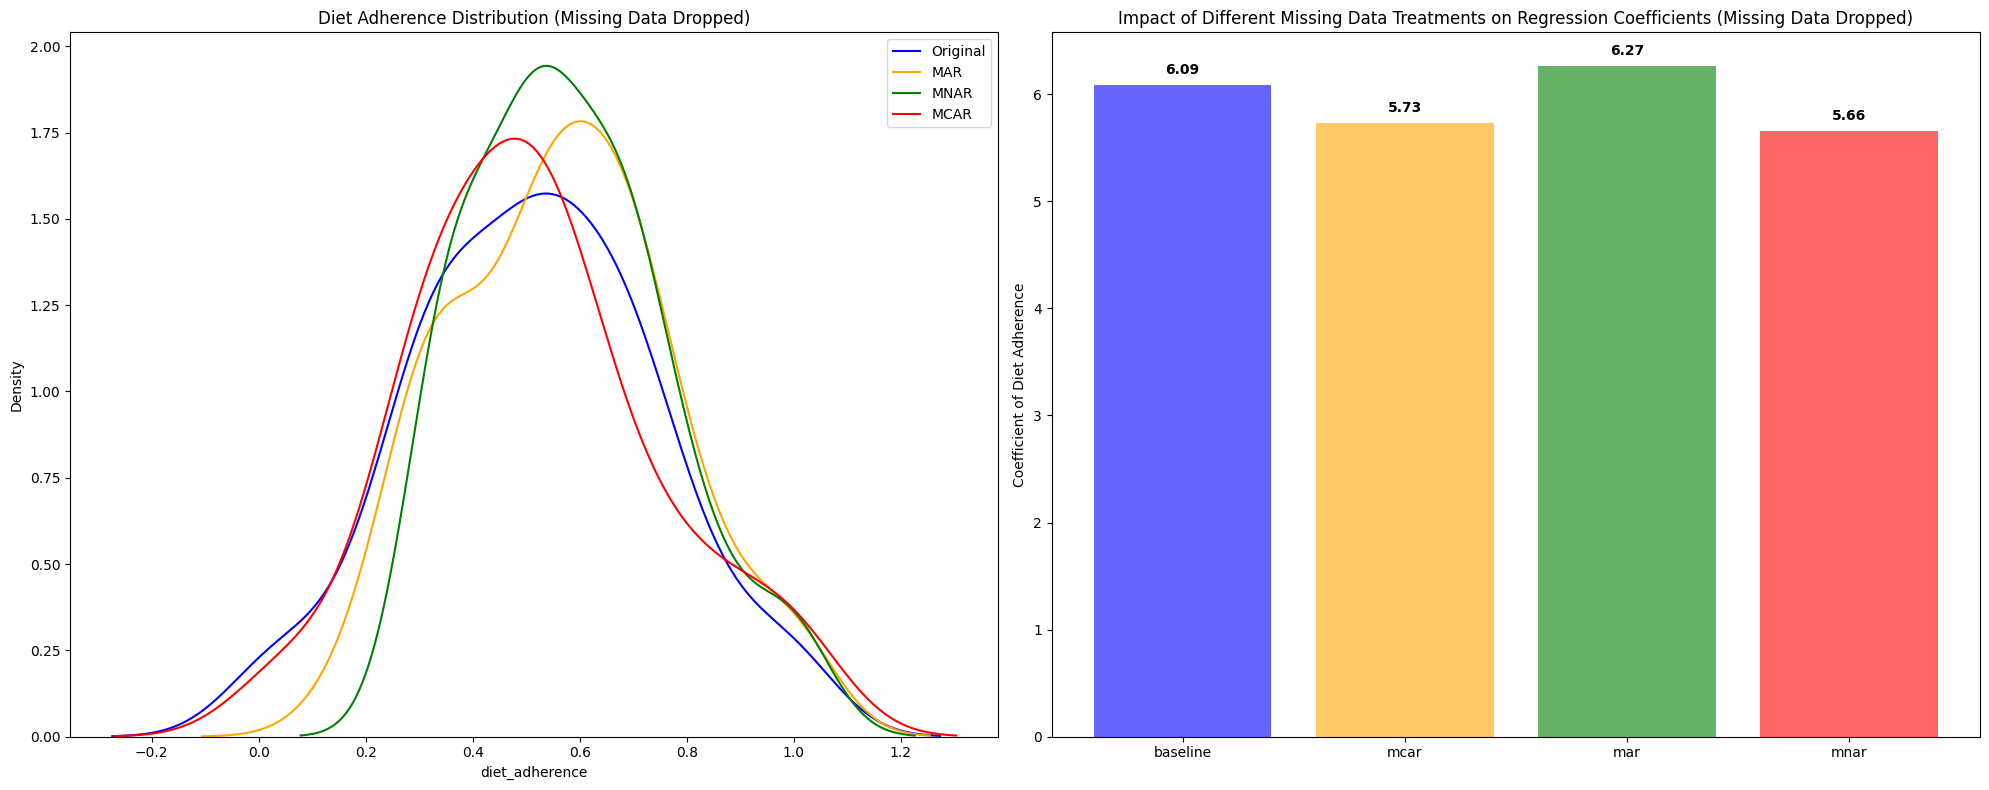

In [749]:
visualize_graphs_side_by_side(data_full, data_mar, data_mnar, data_mcar, 'Diet Adherence Distribution (Missing Data Dropped)', results, 'Impact of Different Missing Data Treatments on Regression Coefficients (Missing Data Dropped)')

### Interpretation of results part 1 (No Imputation)
1. MCAR
* For MCAR (Missing completely at random) 40% of the data from the diet_adherence column was ramdomly removed. 
* In comparison to the baseline model without missing data the data distribution is off and the coefficients estimated in the regression is too low.
2. MAR
* For MAR (Missing at random) 80% of the data from the diet_adherence column for people who are heavier than 80kg was removed. 
* In comparison to the baseline model without missing the coefficient is overestmated.
3. MNAR
* For MNAR (Missing not at random) all data from the diet_adherence column was removed if the adherence to the diet was lower than 30%. 
* In comparison to the baseline model without missing data the coefficent is underestimated

For all three models the data distribution is visually off from the full dataset.


### Simple imputation
Missing data effects the quality of our results, to fight this data can be imputed, which means filling non existent datapoints with estimated data instead of dropping them. 
An easy way to do this is by using Simple Imputation - In this case the missing values are filled with the mean/median value.

In [750]:
# Imputing missing data using Simple Imputation
data_mcar_imputed = data_mcar.copy()
data_mar_imputed = data_mar.copy()
data_mnar_imputed = data_mnar.copy()

# Simple imputation using mean
mean_imputer = SimpleImputer(strategy='mean')
data_mcar_imputed['diet_adherence'] = mean_imputer.fit_transform(data_mcar_imputed[['diet_adherence']]) 
data_mar_imputed['diet_adherence'] = mean_imputer.fit_transform(data_mar_imputed[['diet_adherence']])
data_mnar_imputed['diet_adherence'] = mean_imputer.fit_transform(data_mnar_imputed[['diet_adherence']])

print(data_mcar_imputed.isnull().sum(), '\n')
print(data_mar_imputed.isnull().sum(), '\n')
print(data_mnar_imputed.isnull().sum(), '\n')


initial_weight    0
age               0
diet_adherence    0
weight_loss       0
dtype: int64 

initial_weight    0
age               0
diet_adherence    0
weight_loss       0
dtype: int64 

initial_weight    0
age               0
diet_adherence    0
weight_loss       0
dtype: int64 



In [751]:
# Running regression on imputed data
mcar_imputed_model = linear_regression(data_mcar_imputed)
mar_imputed_model = linear_regression(data_mar_imputed)
mnar_imputed_model = linear_regression(data_mnar_imputed)

results_imputed = pd.DataFrame({
    'baseline': baseline_model,
    'mcar': mcar_imputed_model,
    'mar': mar_imputed_model,
    'mnar': mnar_imputed_model,
})

results_imputed

,baseline,mcar,mar,mnar
coef,6.089676,3.124790,3.939221,2.941375
std_err,0.669708,0.845152,0.700827,0.859883
ci_lower,4.760490,1.447396,2.548273,1.234744
ci_upper,7.418862,4.802183,5.330170,4.648005


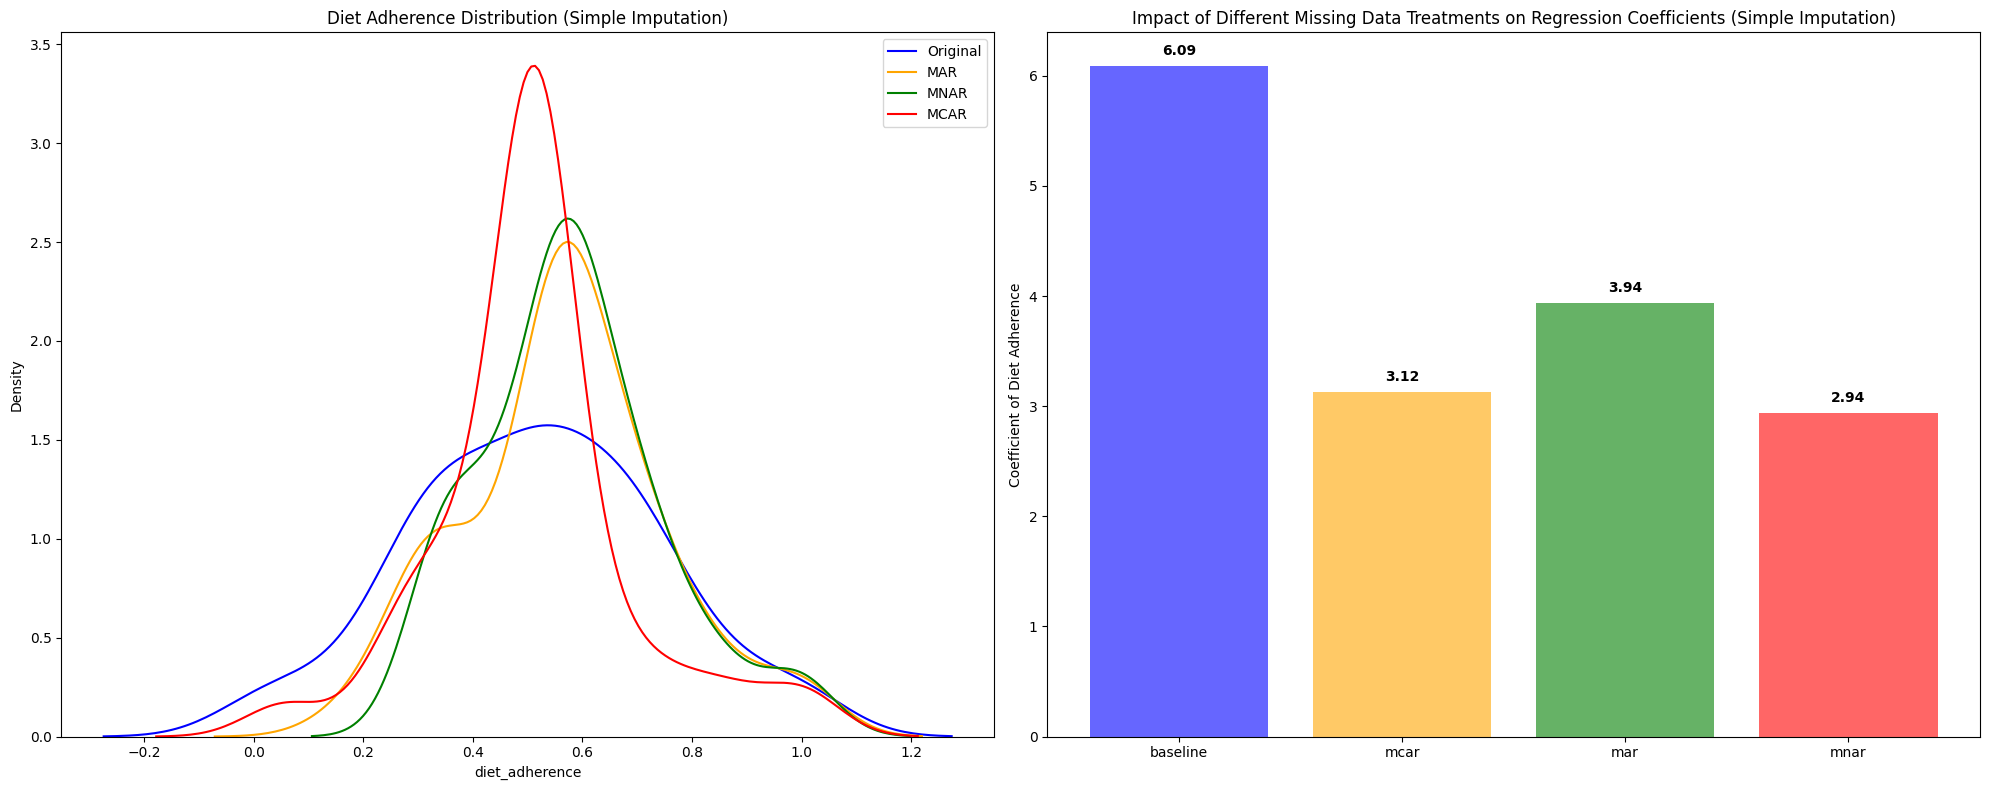

In [752]:
visualize_graphs_side_by_side(data_full, data_mar_imputed, data_mnar_imputed, data_mcar_imputed, 'Diet Adherence Distribution (Simple Imputation)', results_imputed, 'Impact of Different Missing Data Treatments on Regression Coefficients (Simple Imputation)')

### Interpretation of Results (Simple Imputation)
In this case simple imputation does not work at all. The data distributions for each imputed dataset are much narrower and have a higher peak as the baseline model. The regression coefficients reflect this as they all severly underestimate the impact of diet adherence.

### Causal Imputation

#### Steps:
1. Establish an visualize DAG
2. Regression imputation informed by the DAG

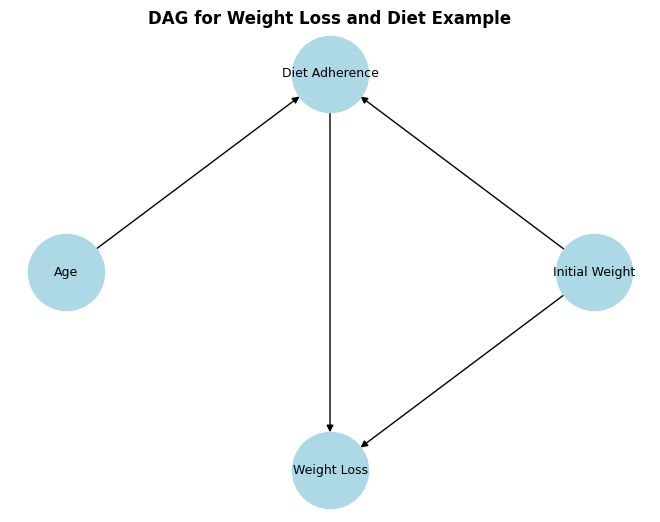

In [776]:
# Define DAG (These are assumptions that we are making about the data and the relationships between variables)
dag = nx.DiGraph()
dag.add_edges_from([('Initial Weight', 'Diet Adherence'), ('Age', 'Diet Adherence'), ('Diet Adherence', 'Weight Loss'), ('Initial Weight', 'Weight Loss')])
pos = nx.circular_layout(dag)
nx.draw(dag, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=9)
plt.title('DAG for Weight Loss and Diet Example', fontweight='bold')
plt.show()

In [754]:
# Causal Imputation
def causal_imputation(data, dependent_var, independent_vars):
    X = data[independent_vars]
    X = sm.add_constant(X)
    y = data[dependent_var]

    model = sm.OLS(y, X, missing='drop').fit()

    missing_indicies = data[dependent_var].isna()
    data.loc[missing_indicies, dependent_var] = model.predict(X[missing_indicies])

    return data

In [755]:
data_mcar_causal = data_mcar.copy()
data_mar_causal = data_mar.copy()
data_mnar_causal = data_mnar.copy()

mcar_causal_results = causal_imputation(data_mcar_causal, 'diet_adherence', ['age', 'initial_weight'])
mar_causal_results = causal_imputation(data_mar_causal, 'diet_adherence', ['age', 'initial_weight'])
mnar_causal_results = causal_imputation(data_mnar_causal, 'diet_adherence',['age', 'initial_weight'])

results_causal = pd.DataFrame({
    'baseline': baseline_model,
    'mcar': linear_regression(mcar_causal_results),
    'mar': linear_regression(mar_causal_results),
    'mnar': linear_regression(mnar_causal_results),
})

results_causal

,baseline,mcar,mar,mnar
coef,6.089676,6.031779,5.971253,6.036921
std_err,0.669708,0.665525,0.658039,0.667259
ci_lower,4.760490,4.710895,4.665228,4.712597
ci_upper,7.418862,7.352662,7.277277,7.361245


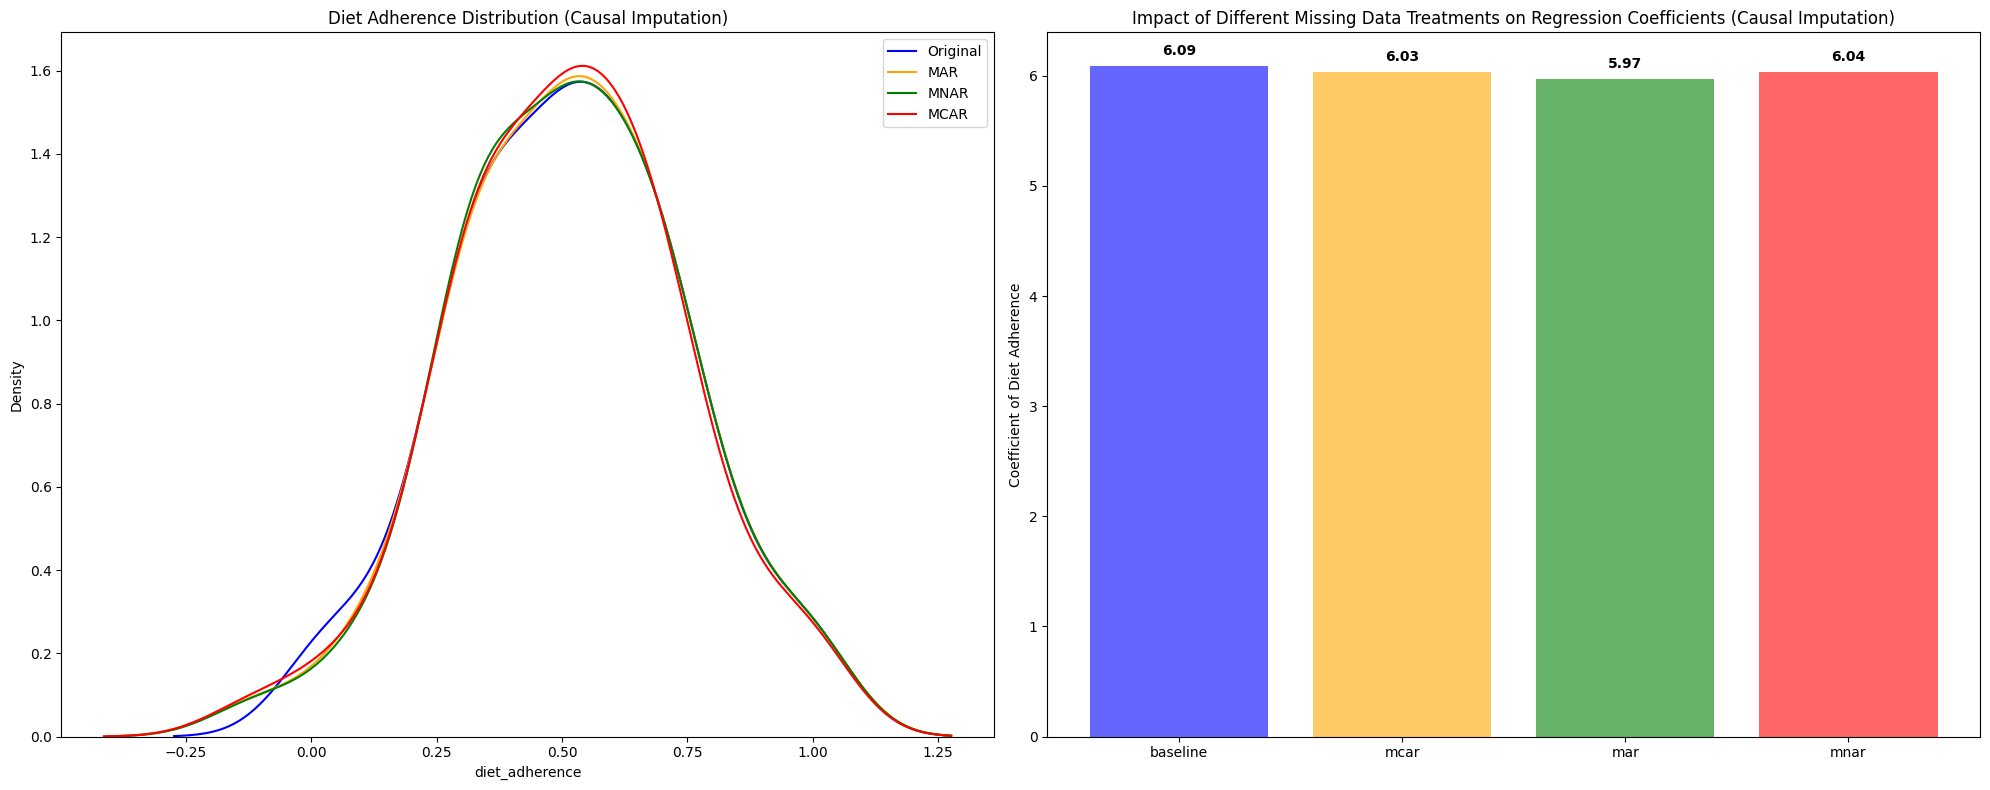

In [756]:
visualize_graphs_side_by_side(data_full, data_mar_causal, data_mnar_causal, data_mcar_causal, 'Diet Adherence Distribution (Causal Imputation)', results_causal, 'Impact of Different Missing Data Treatments on Regression Coefficients (Causal Imputation)')

In [757]:
data_mcar_causal_incomplete = data_mcar.copy()
data_mar_causal_incomplete = data_mar.copy()
data_mnar_causal_incomplete = data_mnar.copy()

mcar_causal_results_incomplete = causal_imputation(data_mcar_causal_incomplete, 'diet_adherence', ['initial_weight'])
mar_causal_results_incomplete = causal_imputation(data_mar_causal_incomplete, 'diet_adherence', ['initial_weight'])
mnar_causal_results_incomplete = causal_imputation(data_mnar_causal_incomplete, 'diet_adherence',['initial_weight'])

results_causal_incomplete = pd.DataFrame({
    'baseline': baseline_model,
    'mcar': linear_regression(mcar_causal_results_incomplete),
    'mar': linear_regression(mar_causal_results_incomplete),
    'mnar': linear_regression(mnar_causal_results_incomplete),
})

results_causal_incomplete

,baseline,mcar,mar,mnar
coef,6.089676,5.732438,6.266171,5.659737
std_err,0.669708,1.024550,0.784957,0.892029
ci_lower,4.760490,3.698989,4.708249,3.889308
ci_upper,7.418862,7.765887,7.824094,7.430167


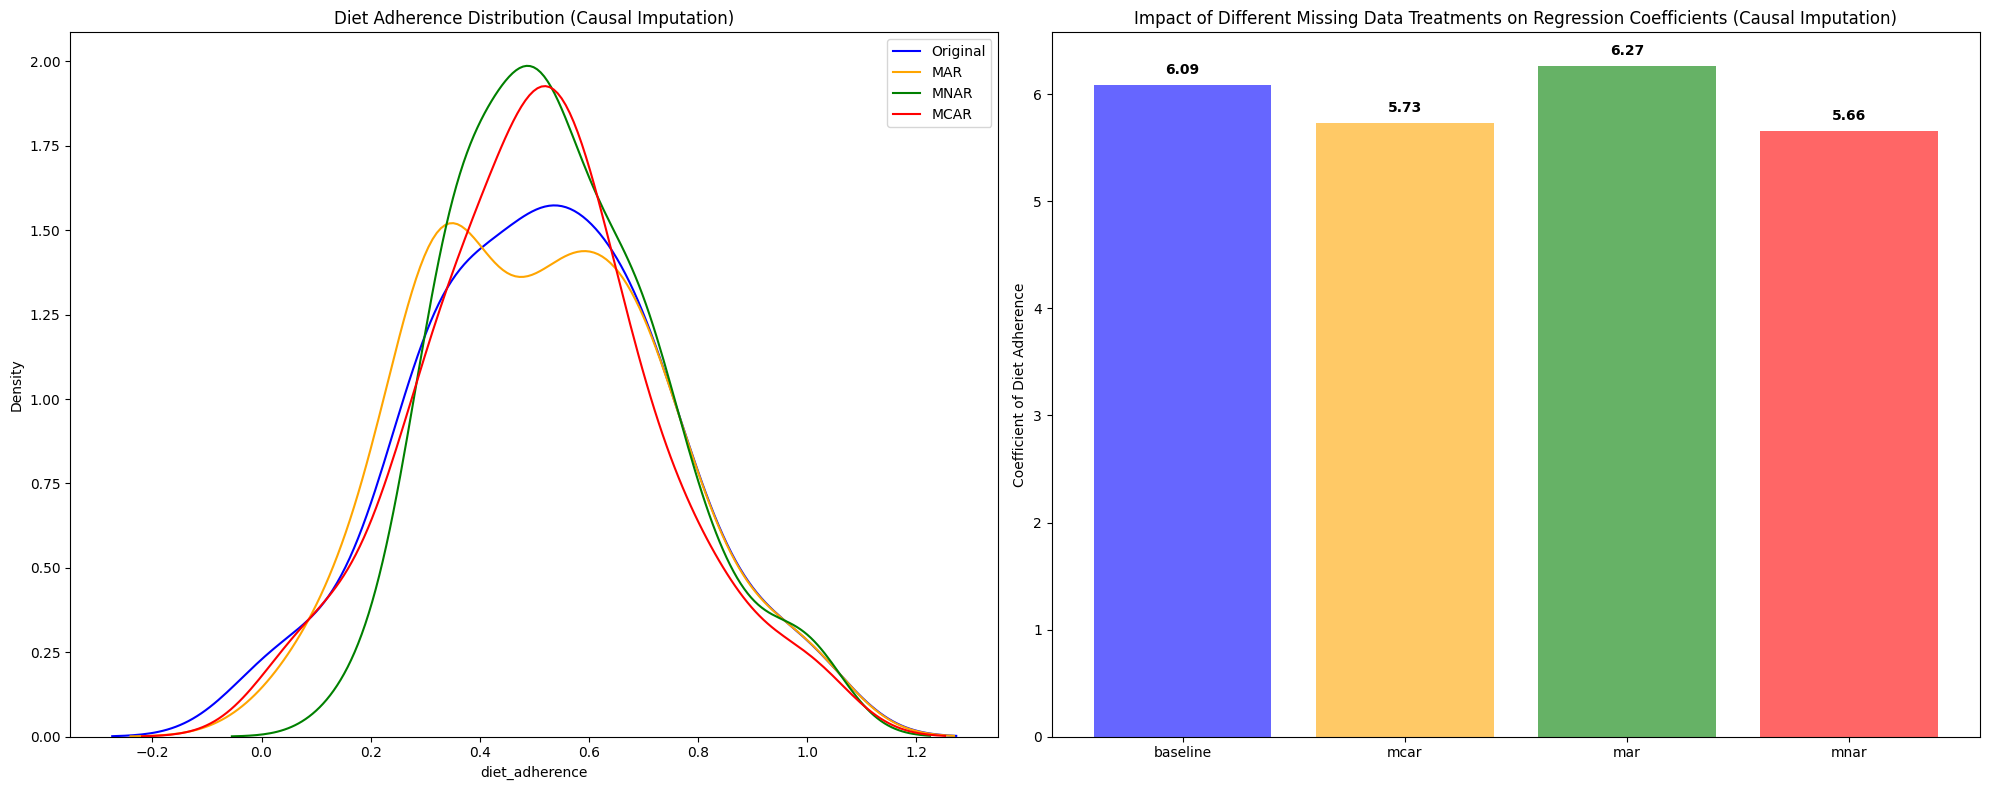

In [758]:
visualize_graphs_side_by_side(data_full, data_mar_causal_incomplete, data_mnar_causal_incomplete, data_mcar_causal_incomplete, 'Diet Adherence Distribution (Causal Imputation)', results_causal_incomplete, 'Impact of Different Missing Data Treatments on Regression Coefficients (Causal Imputation)')

In [759]:
data_mcar_causal_back = data_mcar.copy()
data_mar_causal_back = data_mar.copy()
data_mnar_causal_back = data_mnar.copy()

mcar_causal_results_back = causal_imputation(data_mcar_causal_back, 'diet_adherence', ['weight_loss', 'initial_weight'])
mar_causal_results_back = causal_imputation(data_mar_causal_back, 'diet_adherence', ['weight_loss', 'initial_weight'])
mnar_causal_results_back = causal_imputation(data_mnar_causal_back, 'diet_adherence',[ 'weight_loss', 'initial_weight'])

results_causal_back = pd.DataFrame({
    'baseline': baseline_model,
    'mcar': linear_regression(mcar_causal_results_back),
    'mar': linear_regression(mar_causal_results_back),
    'mnar': linear_regression(mnar_causal_results_back),
})

results_causal_back

,baseline,mcar,mar,mnar
coef,6.089676,7.495116,7.058311,6.913009
std_err,0.669708,0.722517,0.607952,0.667146
ci_lower,4.760490,6.061119,5.851695,5.588910
ci_upper,7.418862,8.929113,8.264928,8.237108


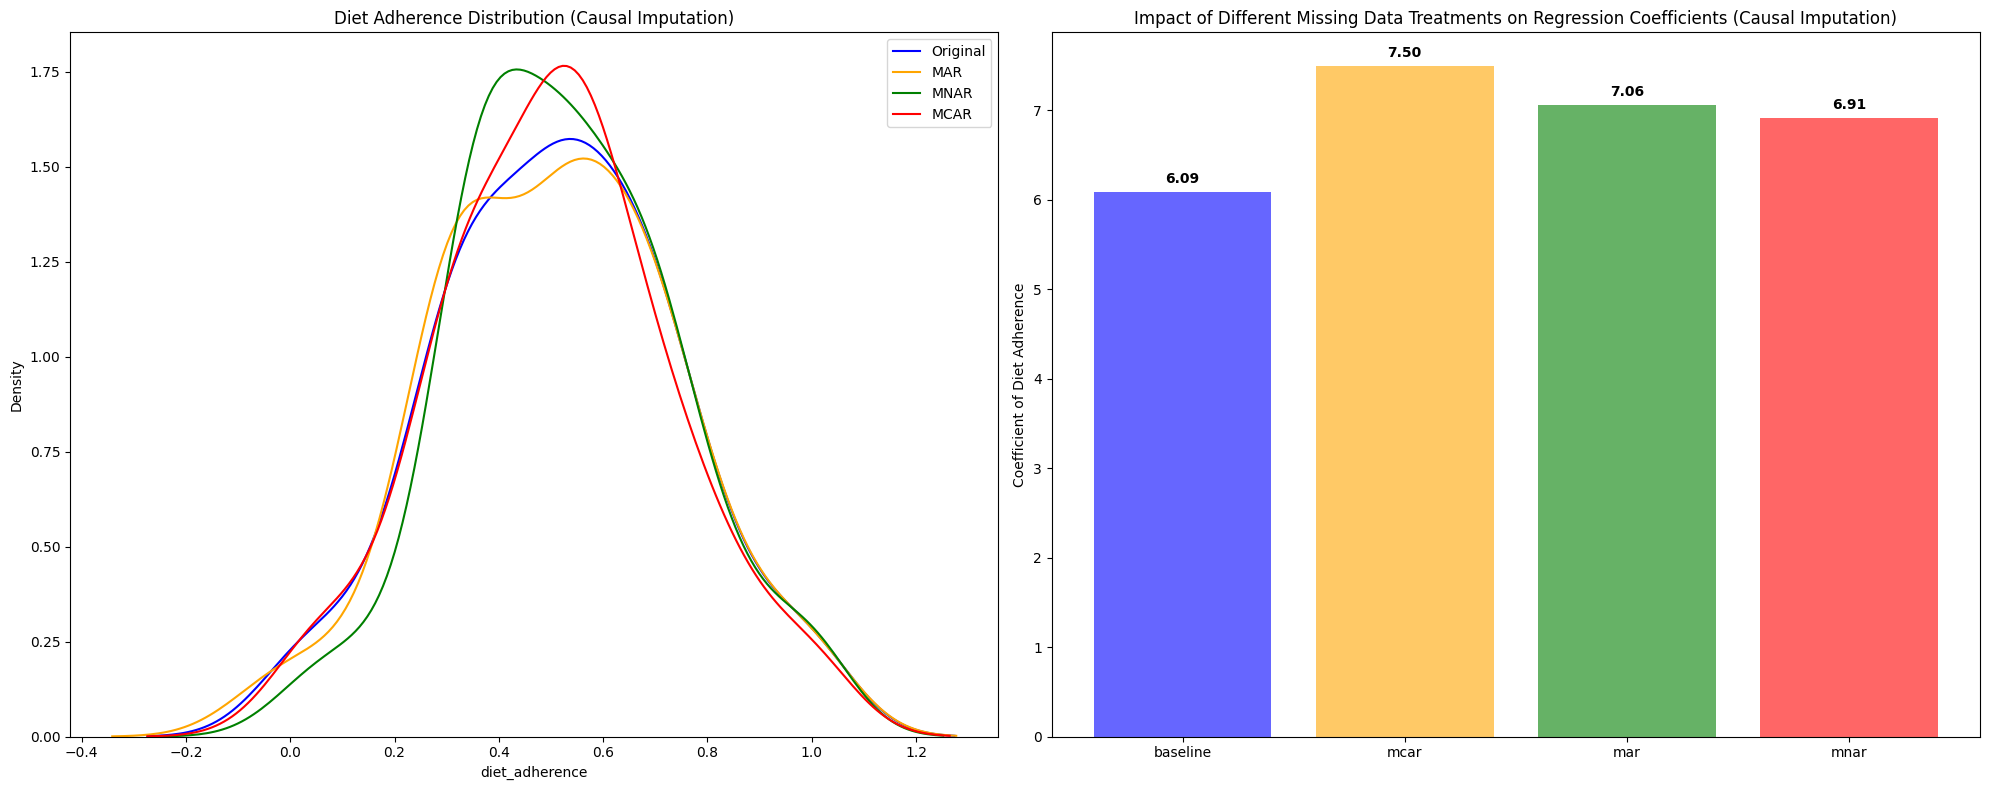

In [760]:
visualize_graphs_side_by_side(data_full, data_mar_causal_back, data_mnar_causal_back, data_mcar_causal_back, 'Diet Adherence Distribution (Causal Imputation)', results_causal_back, 'Impact of Different Missing Data Treatments on Regression Coefficients (Causal Imputation)')

In [761]:
data_mcar_causal_back2 = data_mcar.copy()
data_mar_causal_back2 = data_mar.copy()
data_mnar_causal_back2 = data_mnar.copy()

mcar_causal_results_back2 = causal_imputation(data_mcar_causal_back2, 'diet_adherence', ['weight_loss', 'age'])
mar_causal_results_back2 = causal_imputation(data_mar_causal_back2, 'diet_adherence', ['weight_loss', 'age'])
mnar_causal_results_back2 = causal_imputation(data_mnar_causal_back2, 'diet_adherence',[ 'weight_loss', 'age'])

results_causal_back2 = pd.DataFrame({
    'baseline': baseline_model,
    'mcar': linear_regression(mcar_causal_results_back2),
    'mar': linear_regression(mar_causal_results_back2),
    'mnar': linear_regression(mnar_causal_results_back2),
})

results_causal_back2

,baseline,mcar,mar,mnar
coef,6.089676,6.284939,6.389254,6.610906
std_err,0.669708,0.547717,0.572189,0.600406
ci_lower,4.760490,5.197873,5.253617,5.419266
ci_upper,7.418862,7.372006,7.524892,7.802545


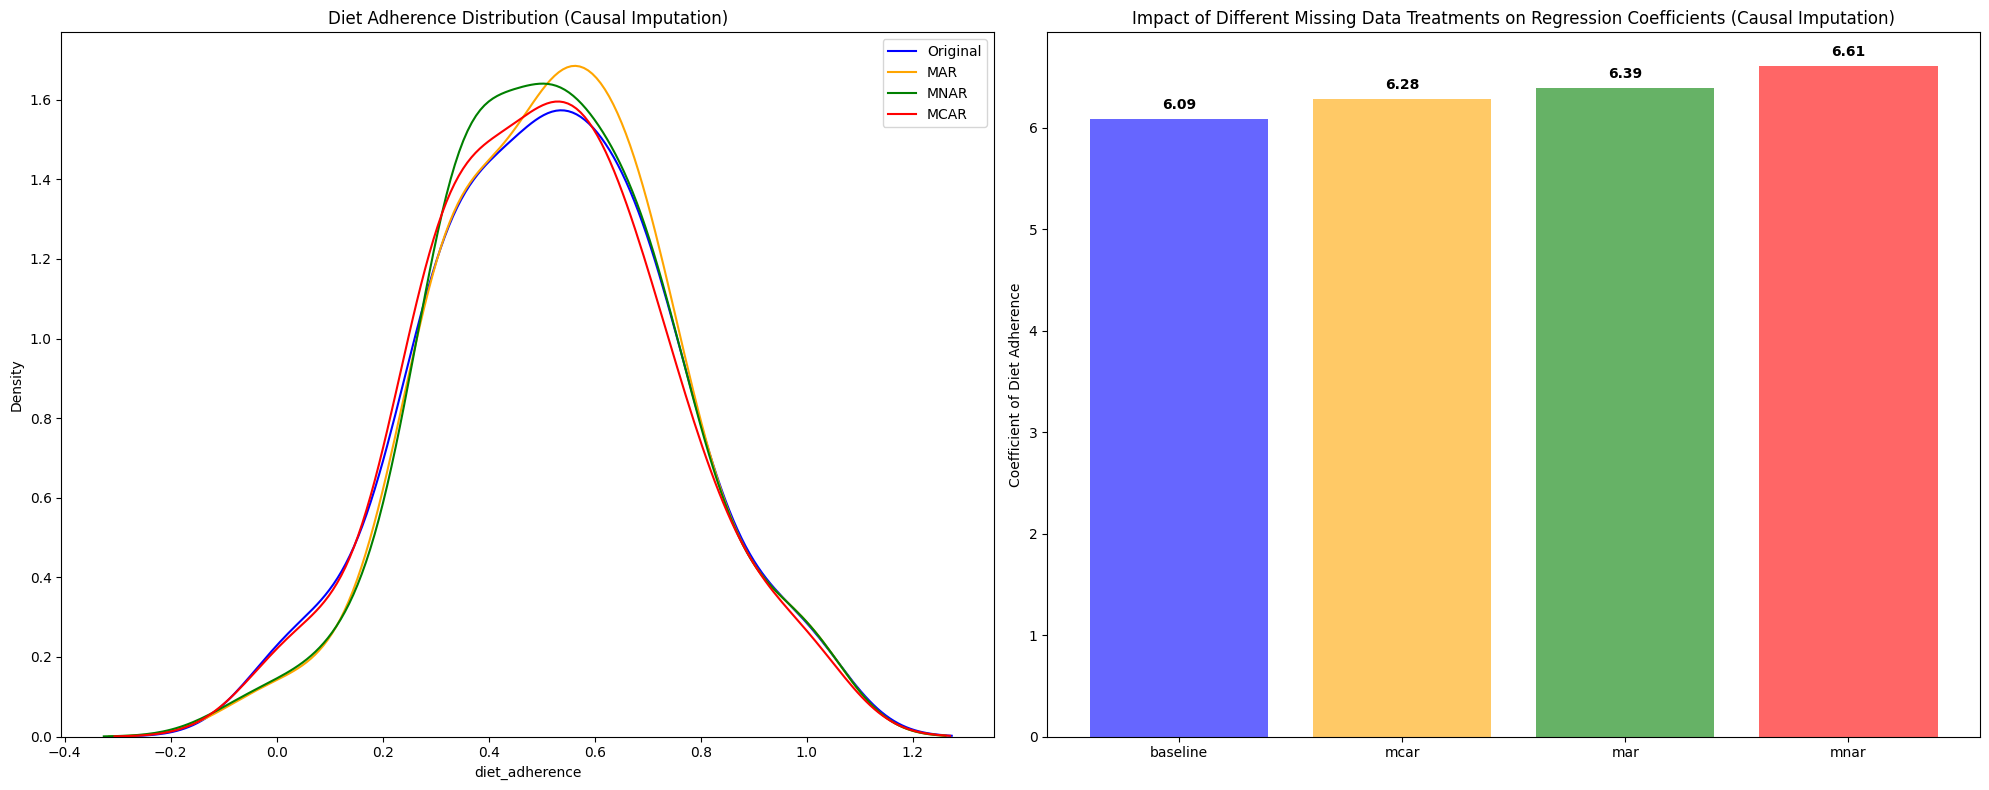

In [762]:
visualize_graphs_side_by_side(data_full, data_mar_causal_back2, data_mnar_causal_back2, data_mcar_causal_back2, 'Diet Adherence Distribution (Causal Imputation)', results_causal_back2, 'Impact of Different Missing Data Treatments on Regression Coefficients (Causal Imputation)')

In [763]:
iterative_imputer = IterativeImputer(max_iter=10, random_state=73)

def iterative_imputation(data):
    imputed_values = iterative_imputer.fit_transform(data[['initial_weight', 'age', 'diet_adherence']])
    data[['initial_weight', 'age', 'diet_adherence']] = imputed_values
    return data

In [764]:
data_mcar_iterative = data_mcar.copy()
data_mar_iterative = data_mar.copy()
data_mnar_iterative = data_mnar.copy()

mcar_iterative_results = iterative_imputation(data_mcar_iterative)
mar_iterative_results = iterative_imputation(data_mar_iterative)
mnar_iterative_results = iterative_imputation(data_mnar_iterative)

In [765]:
mcar_iterative_model = linear_regression(mcar_iterative_results)
mar_iterative_model = linear_regression(mar_iterative_results)
mnar_iterative_model = linear_regression(mnar_iterative_results)

results_iterative = pd.DataFrame({
    'baseline': baseline_model,
    'mcar': mcar_iterative_model,
    'mar': mar_iterative_model,
    'mnar': mnar_iterative_model,
})

results_iterative

,baseline,mcar,mar,mnar
coef,6.089676,6.032255,5.971399,6.037299
std_err,0.669708,0.665592,0.658054,0.667315
ci_lower,4.760490,4.711238,4.665343,4.712864
ci_upper,7.418862,7.353271,7.277455,7.361734


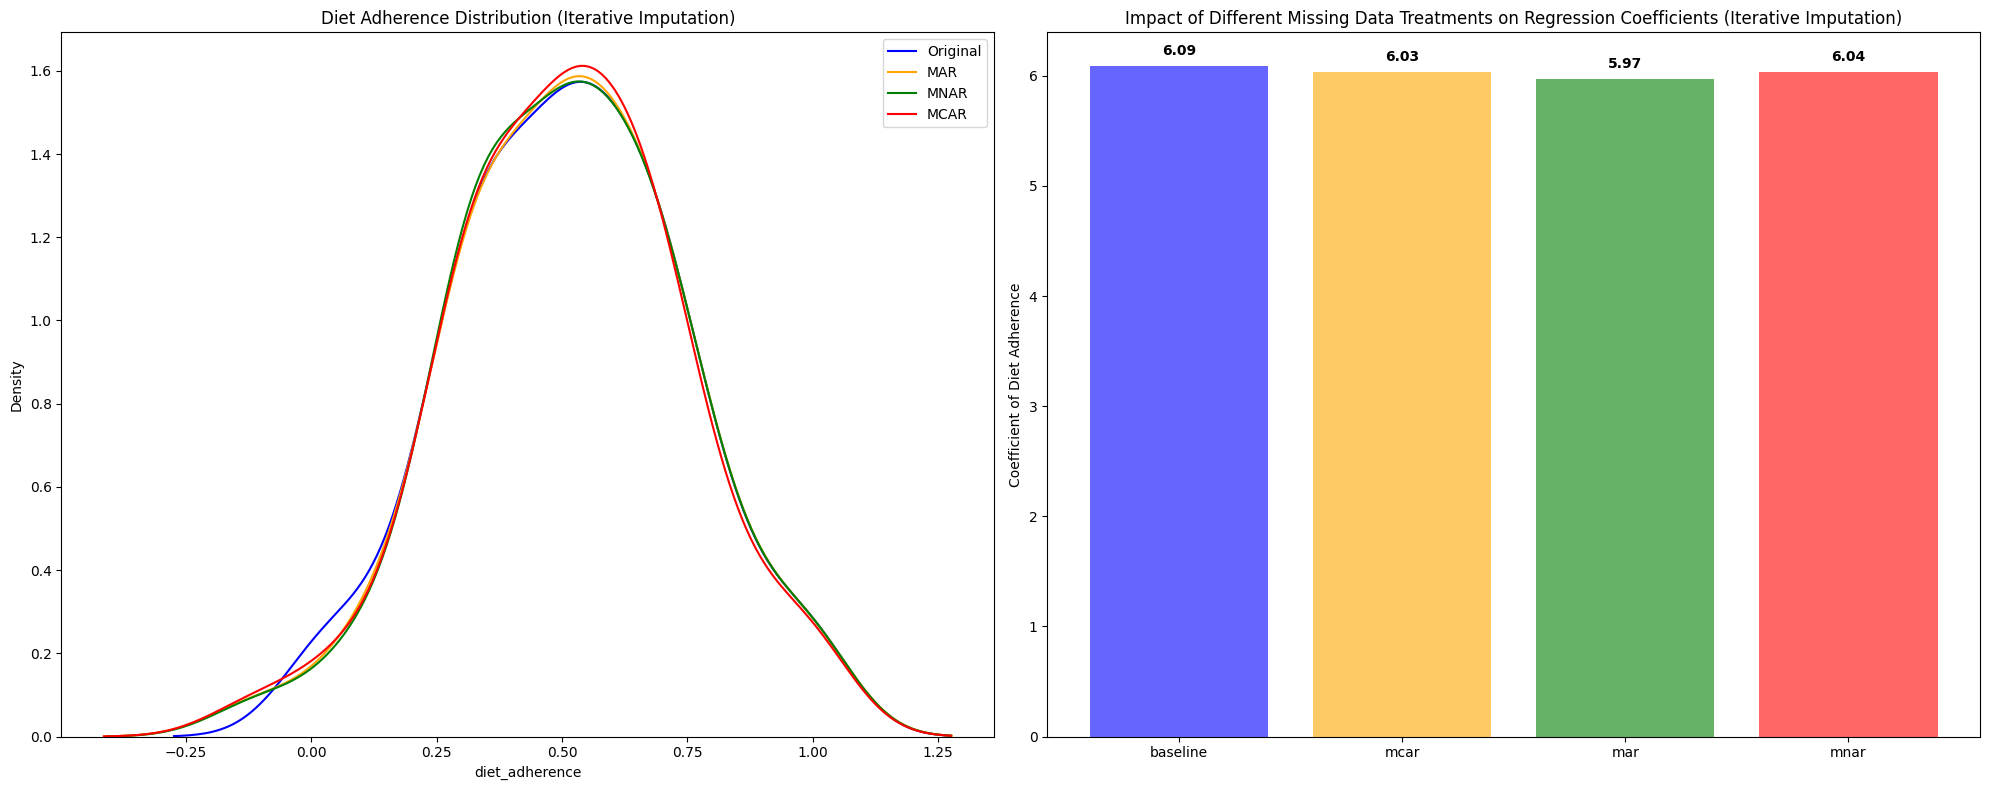

In [766]:
visualize_graphs_side_by_side(data_full, data_mar_iterative, data_mnar_iterative, data_mcar_iterative, 'Diet Adherence Distribution (Iterative Imputation)', results_iterative, 'Impact of Different Missing Data Treatments on Regression Coefficients (Iterative Imputation)')

### Interpretation of Results (Causal and Iterative Imputation)
Causal imputation, when used as represented in the DAG, and Interative Imputation produce almost identical results. In this case both are really great and able to impute the missing data well, even for the hard to impute case of MCAR. 
However, misinterpreting or erroneous contstruction of the DAG can lead to bad imputation results. This is shown in the three examples using either wrong causal relationships or incomplete representation of the realtionships (data_causal_inclomplete, data_causal_bak and data_causal_back2). In all these cases the regression model used for imputation produced worse results, and hence, the resulting coefficients by calculated in the predictive regression model were off further from the baseline model as the well informed causal approach (or Iterative Imputer approach).


### Further Visualizations

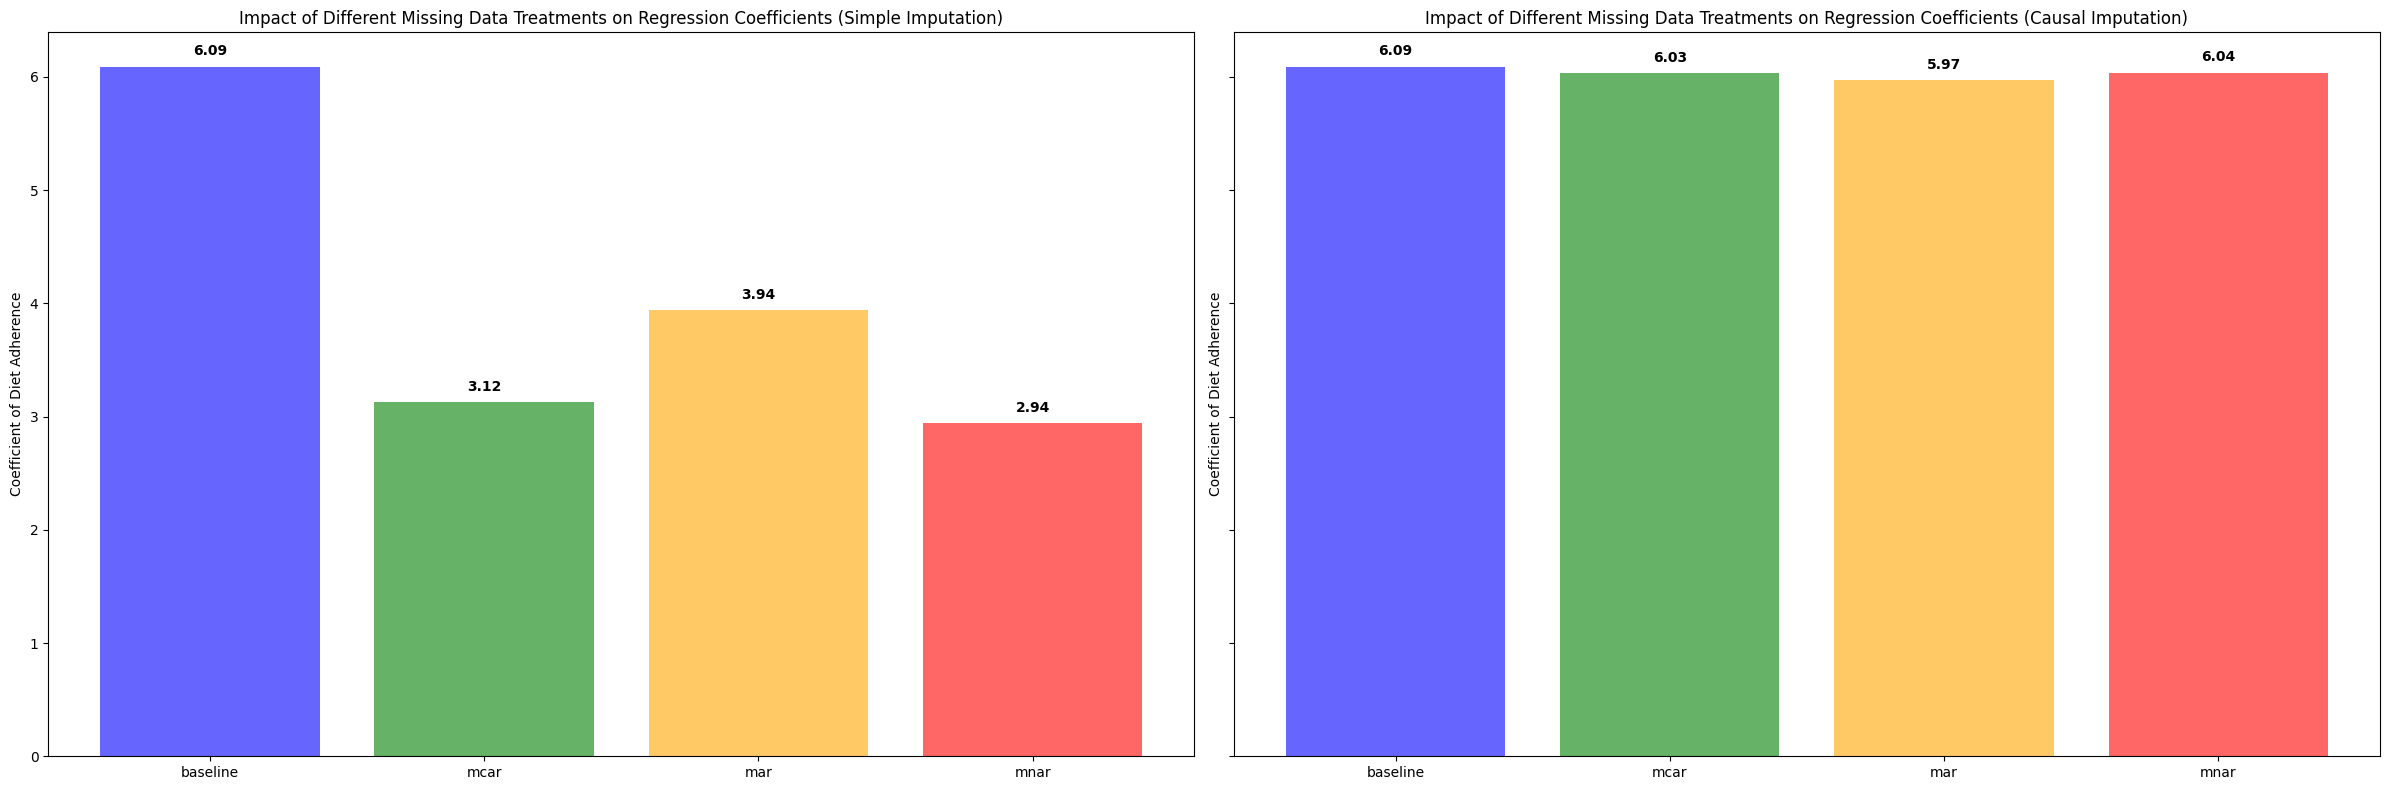

In [767]:
visualize_regression_results_side_by_side(
    results_imputed, 
    'Impact of Different Missing Data Treatments on Regression Coefficients (Simple Imputation)',
    results_causal,
    'Impact of Different Missing Data Treatments on Regression Coefficients (Causal Imputation)'
)

In [768]:
def visualize_distributions_side_by_side(original, simple_mar, simple_mnar, simple_mcar, causal_mar, causal_mnar, causal_mcar):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), sharey=True)
    
    def plot_distributions(ax, original, imputed_mar, imputed_mnar, imputed_mcar, title):
        sns.kdeplot(original['diet_adherence'].dropna(), label='Original', color='blue', ax=ax)
        sns.kdeplot(imputed_mar['diet_adherence'].dropna(), label='MAR', color='orange', ax=ax)
        sns.kdeplot(imputed_mnar['diet_adherence'].dropna(), label='MNAR', color='red', ax=ax)
        sns.kdeplot(imputed_mcar['diet_adherence'].dropna(), label='MCAR', color='green', ax=ax)
        ax.set_title(title)
        ax.legend()

    plot_distributions(axes[0], original, simple_mar, simple_mnar, simple_mcar, 'Distributions after Simple Imputation')
    plot_distributions(axes[1], original, causal_mar, causal_mnar, causal_mcar, 'Distributions after Causal Imputation')

    plt.tight_layout()
    plt.show()

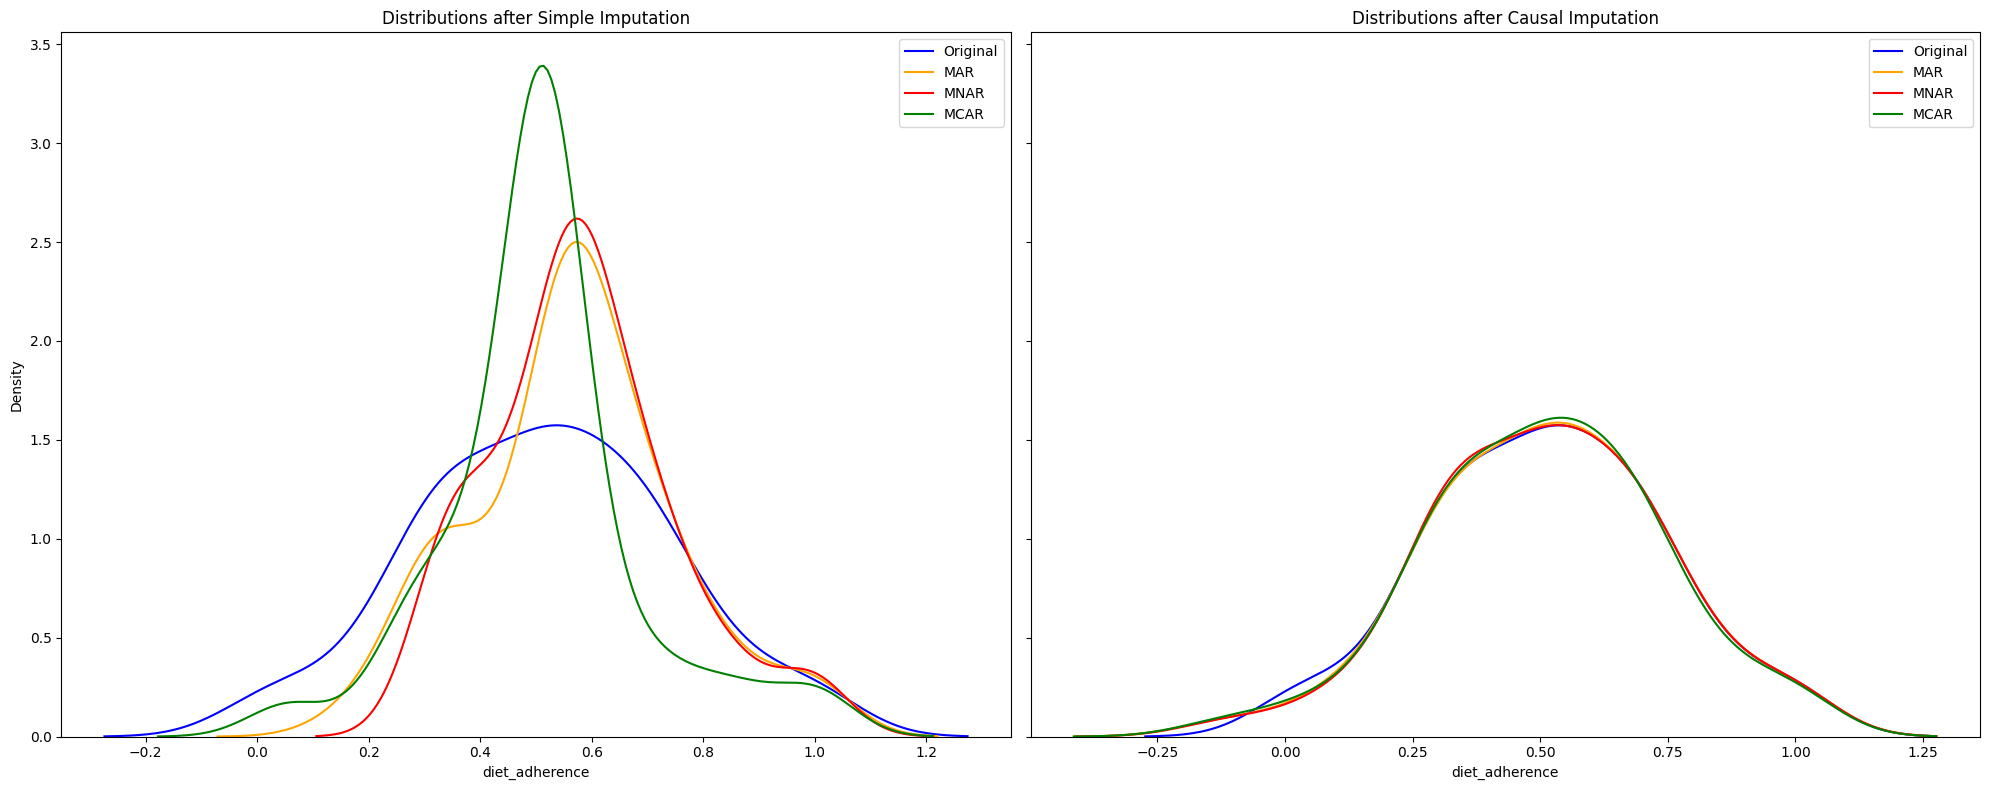

In [769]:
# Visualizing the distributions side by side
visualize_distributions_side_by_side(
    data_full, 
    data_mar_imputed, 
    data_mnar_imputed, 
    data_mcar_imputed,
    data_mar_causal,
    data_mnar_causal,
    data_mcar_causal
)